In [1]:
import os
import sys
import random
import warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K

import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import transform

from tqdm import tqdm
from itertools import chain


import shutil
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../DATA/stage1_train/'
TEST_PATH = '../DATA/stage1_test/'
logs_path = './tensorflow_logs/'

In [3]:
# get train and test IDS
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int8)

    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask,mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\xuke\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:24<00:00,  8.73it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 59.01it/s]


Done!


In [4]:
# Model
def get_variable(name,shape):
    return tf.get_variable(name, shape, initializer = tf.contrib.layers.xavier_initializer())
# data
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)
    #image_resized = tf.image.resize_images(image_decoded, [28, 28])

    return image_decoded, label

# 不再是二分类而是多分类了，不能用binary_crossentropy
# loss,iou
def loss_function(y_pred, y_true): #y_true 0 or 255/y_pred 0 to 1
#     I = tf.reduce_sum(tf.multiply(y_pred,y_true))
#     U = tf.reduce_sum(y_pred)+tf.reduce_sum(y_true)-I
#     cost = I/U
    cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true,predictions=y_pred))
    return -cost
#def mIoU
#     yp = y_pred
#     yt = y_true/255
#     I = tf.multiply(yp,yt)
#     U = yp+yt
#     IoU = tf.reduce_sum(I,axis=[1,2,3])/tf.reduce_sum(U,axis=[1,2,3])
#     cost = tf.reduce_mean(-IoU)

In [5]:
batch_size = 16
num_steps = 500
display_step = 50
sess = tf.Session()

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()

In [7]:
sess.run(iterator.initializer)
X,Y = iterator.get_next()

In [8]:
IMG_HEIGHT=IMG_WIDTH=128
IMG_CHANNELS=3
learning_rate=0.00001
with tf.name_scope('input'):
    x_ = tf.placeholder(tf.float32, shape=(None,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    y_ = tf.placeholder(tf.float32, shape=(None,IMG_HEIGHT, IMG_WIDTH))
    #y_cn = tf.placeholder(tf.float32, shape=(None,IMG_HEIGHT, IMG_WIDTH, MASKS_NUM))
    #y_fc = tf.placeholder(tf.float32,shape=(None,1))#None means the batch size
with tf.name_scope('model'):
    ## CONTRACTING PATH
    ### U1
    with tf.name_scope('U1') as scope:
        W1_1 = get_variable("W1_1",[3,3,3,16]) #[3,3,3,16] [height,width,input_chanel,output_channel]
                                                ######image channel is 4 while input channel is 3?????
        Z1 = tf.nn.conv2d(tf.cast(X,tf.float32),W1_1,strides = [1,1,1,1],padding = 'SAME') #stride[1,1,1,1] [batch stride,height stride,width stride,channel stride]
        A1 = tf.nn.elu(Z1)
        W1_2 = get_variable('W1_2',[3,3,16,16])
        Z2 = tf.nn.conv2d(A1,W1_2,strides = [1,1,1,1],padding = 'SAME')
        A2 = tf.nn.elu(Z2)
        P1 = tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')#ksize=[pool size on batch,pool size on height,pool size on width,pool size on channel]
    ### u2
    with tf.name_scope('U2') as scope:
        W2_1 = get_variable('W2_1',[3,3,16,32])
        Z3 = tf.nn.conv2d(P1,W2_1,strides = [1,1,1,1],padding = 'SAME')
        A3 = tf.nn.elu(Z3)
        W2_2 = get_variable('W2_2',[3,3,32,32])
        Z4 = tf.nn.conv2d(A3,W2_2,strides = [1,1,1,1],padding = 'SAME')
        A4 = tf.nn.elu(Z4)
        P2 = tf.nn.max_pool(A4,ksize=[1,2,2,1],strides = [1,2,2,1],padding='SAME')
    ### u3
    with tf.name_scope('U3') as scope:
        W3_1 = get_variable('W3_1',[3,3,32,64])
        Z5 = tf.nn.conv2d(P2,W3_1,strides=[1,1,1,1],padding = 'SAME')
        A5 = tf.nn.elu(Z5)
        W3_2 = get_variable('W3_2',[3,3,64,64])
        Z6 = tf.nn.conv2d(A5,W3_2,strides=[1,1,1,1],padding='SAME')
        A6 =tf.nn.elu(Z6)
        P3 = tf.nn.max_pool(A6,ksize=[1,2,2,1],strides = [1,2,2,1],padding='SAME')
    ### u4
    with tf.name_scope('U4') as scope:
        W4_1 =get_variable('W4_1',[3,3,64,128])
        Z7 = tf.nn.conv2d(P3,W4_1,strides=[1,1,1,1],padding='SAME')
        A7 = tf.nn.elu(Z7)
        W4_2 =get_variable('W4_2',[3,3,128,128])
        Z8 = tf.nn.conv2d(A7,W4_2,strides = [1,1,1,1],padding = 'SAME')
        A8 = tf.nn.elu(Z8)
        P4 = tf.nn.max_pool(A8,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    ### Bottom layer
    ### u5
    with tf.name_scope('U5') as scope:
        W5_1 = get_variable('W5_1',[3,3,128,256])
        Z9 = tf.nn.conv2d(P4,W5_1,strides=[1,1,1,1],padding='SAME')
        A9 = tf.nn.elu(Z9)
        W5_2 = get_variable('W5_2',[3,3,256,256])
        Z10 = tf.nn.conv2d(A9,W5_2,strides=[1,1,1,1],padding = 'SAME')
        A10 = tf.nn.elu(Z10)
        U1 = tf.layers.conv2d_transpose(A10,filters = 128,kernel_size=2,strides=2,padding='SAME')# important,转置卷积这里需要进行说明
        U1 = tf.concat([U1,A8],3)# 结合的时候为什么是直接结合的，按照结构的图像的话不是这样的啊
    
    ### EXPANSIVE PATH
    ### u6
    with tf.name_scope('U6') as scope:
        W6_1 = get_variable('W6_1',[3,3,256,128])
        Z11 = tf.nn.conv2d(U1,W6_1,strides=[1,1,1,1],padding='SAME')
        A11 = tf.nn.elu(Z11)
        W6_2 = get_variable('W6_2',[3,3,128,128])
        Z12 = tf.nn.conv2d(A11,W6_2,strides=[1,1,1,1],padding='SAME')
        A12 = tf.nn.elu(Z12)
        U2 = tf.layers.conv2d_transpose(A12,filters = 64,kernel_size=2,strides=2,padding='SAME')
        U2 = tf.concat([U2,A6],3)
    ### u7
    with tf.name_scope('U7') as scope:
        W7_1 = get_variable('W7_1',[3,3,128,64])
        Z13 = tf.nn.conv2d(U2,W7_1,strides=[1,1,1,1],padding='SAME')
        A13 =tf.nn.elu(Z13)
        W7_2 = get_variable('W7_2',[3,3,64,64])
        Z14 = tf.nn.conv2d(A13,W7_2,strides=[1,1,1,1],padding='SAME')
        A14 =tf.nn.elu(Z14)
        U3 = tf.layers.conv2d_transpose(A14,filters = 32,kernel_size=2,strides=2,padding='SAME')
        U3 = tf.concat([U3,A4],3)
    ### u8
    with tf.name_scope('U8') as scope:
        W8_1 = get_variable('W8_1',[3,3,64,32])
        Z15 = tf.nn.conv2d(U3,W8_1,strides=[1,1,1,1],padding='SAME')
        A15= tf.nn.elu(Z15)
        W8_2 = get_variable('W8_2',[3,3,32,32])
        Z16 = tf.nn.conv2d(A15,W8_2,strides=[1,1,1,1],padding='SAME')
        A16 = tf.nn.elu(Z16)
        U4 = tf.layers.conv2d_transpose(A16,filters=16,kernel_size=2,strides=2,padding='SAME')
        U4 = tf.concat([U4,A2],3)
    ### u9
    with tf.name_scope('U9') as scope:
        W9_1 = get_variable('W9_1',[3,3,32,16])
        Z17 = tf.nn.conv2d(U4,W9_1,strides=[1,1,1,1],padding='SAME')
        A17 = tf.nn.elu(Z17)
        W9_2 = get_variable('W9_2',[3,3,16,16])
        Z18 = tf.nn.conv2d(A17,W9_2,strides=[1,1,1,1],padding='SAME')
        A18 = tf.nn.elu(Z18)
        W9_3 = get_variable('W9_3',[1,1,16,1])#?????? 4*1=4 但是网络的结构图似乎是2
        Z19 = tf.nn.conv2d(A18,W9_3,strides=[1,1,1,1],padding='SAME')
        A19 = tf.nn.relu(Z19)
    ### output
    with tf.name_scope('unet_output') as scope:
        y_pred = A19
    tf.summary.histogram('y_pred', y_pred)

In [9]:
# build the graph as a dictionary
with tf.name_scope('loss'):
    with tf.variable_scope('loss',reuse=tf.AUTO_REUSE) as scope:
        loss = loss_function(y_pred,tf.cast(Y,tf.float32))
with tf.name_scope('optimizer'):
    with tf.variable_scope('ADAM',reuse=tf.AUTO_REUSE) as scope:
        # Gradient descent
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss,global_step=tf.train.get_global_step())
# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [10]:
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())    

In [13]:
sess.run(init)
# op to write logs to Tensorboard
summary_writer = tf.summary.FileWriter(logs_path, graph=sess.graph)
for step in range(1,2*num_steps+1):
    sess.run(train_op)
    summary = sess.run(merged_summary_op)
    summary_writer.add_summary(summary, step)
    if step % display_step==0 or step ==1:
    # Write logs at every iteration
        LOSS = sess.run(loss)
        print("Step " + str(step) + ", Minibatch Loss= "+str(LOSS))

Step 1, Minibatch Loss= -137.11325
Step 50, Minibatch Loss= -204.16745
Step 100, Minibatch Loss= -251.09584
Step 150, Minibatch Loss= -230.2413
Step 200, Minibatch Loss= -151.79134
Step 250, Minibatch Loss= -159.29593
Step 300, Minibatch Loss= -122.93513
Step 350, Minibatch Loss= -216.70146
Step 400, Minibatch Loss= -237.50607
Step 450, Minibatch Loss= -235.26945
Step 500, Minibatch Loss= -149.85399
Step 550, Minibatch Loss= -220.79337
Step 600, Minibatch Loss= -196.09865
Step 650, Minibatch Loss= -262.4346
Step 700, Minibatch Loss= -170.153
Step 750, Minibatch Loss= -266.6319
Step 800, Minibatch Loss= -179.70212
Step 850, Minibatch Loss= -264.34393
Step 900, Minibatch Loss= -191.70184
Step 950, Minibatch Loss= -240.36794
Step 1000, Minibatch Loss= -232.99326


In [14]:
summary_writer.close()

In [21]:
[x,y,z19,a19] = sess.run([X,Y,Z19,A19])

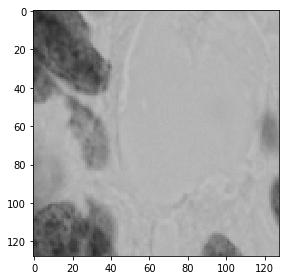

In [22]:
# input image
imshow(x[0,:,:,0])
plt.show()

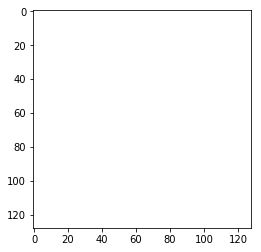

In [23]:
plt.imshow(z19[0,:,:,0],'gray')
plt.show()

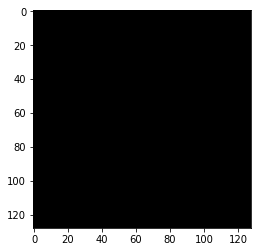

In [24]:
plt.imshow(a19[0,:,:,0],'gray')
plt.show()

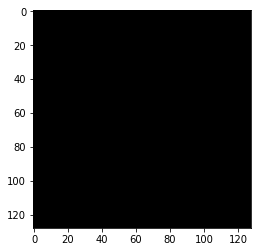

In [25]:
plt.imshow(yp[0,:,:,0],'gray')
plt.show()

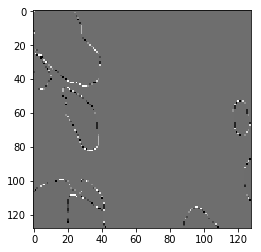

In [26]:
plt.imshow(y[0,:,:,0],'gray')

In [ ]:
np.max(y)